
# Introduction: GRU + XGBoost Hybrid

### GRU (Gated Recurrent Unit)
- A type of **Recurrent Neural Network (RNN)** designed for sequential data like time series.  
- Captures **temporal dependencies** : meaning it learns patterns across days, weeks, or months.  
- Uses **gates (update & reset)** to control how much past information is remembered or forgotten.  
- Advantages for sales forecasting:  
  - Learns complex demand patterns.  
  - Handles long sequences efficiently.  
  - More lightweight than LSTMs (faster training).  

### XGBoost (Extreme Gradient Boosting)
- A **tree-based ensemble learning algorithm**.  
- Excels at modeling **non-linear relationships** and **interactions** between features.  
- Uses gradient boosting to iteratively improve predictions.  
- Advantages for sales forecasting:  
  - Can use **exogenous variables** (holidays, seasons, lags, rolling stats).  
  - Strong at capturing **non-sequential drivers** of sales.  
  - Robust to missing data and noise.  

### Why Combine GRU + XGBoost?
- **GRU strength** → learns *temporal patterns* (sequential sales behavior).  
- **XGBoost strength** → learns *residual errors* and *feature-driven effects* (holidays, seasonality, sudden spikes).  
- The hybrid approach ensures:  
  Better accuracy by correcting GRU’s errors.  
  Robustness against irregular sales spikes.  
  Flexibility across short and medium forecast horizons.  

**In short:**  
> GRU models *what usually happens over time*;  
> XGBoost explains *why exceptions happen*.  
Together, they provide a balanced, powerful sales forecasting solution.


## Unified GRU + XGBoost Hybrid for Pharmacy Sales Forecasting

This notebook presents a **hybrid forecasting model** that combines Gated Recurrent Units (GRU) and XGBoost for predicting daily sales of 8 drug categories (**M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06**) using `holidays.csv`. It follows a step-by-step structure, where each code block is preceded by an explanation of the approach.


### 1. Installing Dependencies
We first install the correct version of **XGBoost** to ensure compatibility and consistent model performance.

In [1]:
!pip install xgboost==2.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.4
    Uninstalling xgboost-3.0.4:
      Successfully uninstalled xgboost-3.0.4


### 2. Importing Libraries
We import essential libraries for data processing, visualization, preprocessing, deep learning (GRU), and gradient boosting (XGBoost).

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### 3. Loading Dataset
We read the `holidays.csv` file, parse dates, and set the **date column** as the index. We also define drug categories to forecast.

In [3]:
df = pd.read_csv("/content/holidays.csv")
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index('datum')

# Drug columns
drug_cols = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

### 4. Feature Engineering
We include **holiday effects** and **calendar features** (day of week, month, week of year, quarter) to capture seasonality.

In [4]:
# Exogenous features
exog_cols = ['public_holiday', 'new_year', 'statehood_day', 'labor_day', 'armistice_day',
             'orthodox_christmas', 'orthodox_easter_sunday', 'orthodox_easter_monday',
             'orthodox_good_friday', 'orthodox_holy_saturday', 'cold_flu_season', 'pollen_season']
exog_cols = [c for c in exog_cols if c in df.columns]
exog = df[exog_cols].fillna(0)

# Calendar features
calendar = pd.DataFrame({
    'dow': df.index.dayofweek,
    'month': df.index.month,
    'weekofyear': df.index.isocalendar().week.astype(int),
    'quarter': df.index.quarter
}, index=df.index)

### 5. Utility Functions
We define helper functions for metrics (SMAPE), lag features, rolling statistics, GRU model builder, and recursive hybrid forecasts.

In [5]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.maximum(denom, 1e-8)
    return float(np.mean(diff) * 100.0)

def create_lags(series, lags=14):
    return pd.DataFrame({f'lag_{i}': series.shift(i) for i in range(1, lags+1)})

def create_rolling(series):
    return pd.DataFrame({
        'roll_mean_3': series.rolling(3).mean(),
        'roll_mean_7': series.rolling(7).mean(),
        'roll_mean_14': series.rolling(14).mean(),
        'roll_std_7': series.rolling(7).std(),
        'roll_std_14': series.rolling(14).std()
    })

def build_gru(seq_len=30, units=128, lr=2.5e-3, dropout=0.2):
    m = models.Sequential([
        layers.Input(shape=(seq_len, 1)),
        layers.GRU(units, dropout=dropout, return_sequences=True),
        layers.GRU(units//2, dropout=dropout, return_sequences=False),
        layers.Dense(1)
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    return m

In [6]:
# --- Additional utilities required for the hybrid pipeline ---
def make_supervised(values, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(values)):
        X.append(values[i-seq_len:i])
        y.append(values[i])
    X = np.asarray(X).reshape(-1, seq_len, 1).astype('float32')
    y = np.asarray(y).astype('float32')
    return X, y

def prepare_future_exog(df_all, exog_cols, start_date, periods=5):
    future_dates = pd.date_range(start=start_date, periods=periods, freq='D')
    fut = pd.DataFrame(0, index=future_dates, columns=exog_cols)
    if len(exog_cols):
        fut.loc[:, exog_cols] = df_all[exog_cols].iloc[-1].values
    fut_cal = pd.DataFrame({
        'dow': fut.index.dayofweek,
        'month': fut.index.month,
        'weekofyear': fut.index.isocalendar().week.astype(int),
        'quarter': fut.index.quarter
    }, index=future_dates)
    return fut, fut_cal

def roll_forecast(values, start_idx, horizon, scaler, gru_model, seq_len, xgb_model, xgb_feats):
    """Recursive hybrid forecast: GRU next-step + XGB residual correction."""
    hist = values[:start_idx].tolist()
    preds = []
    for step in range(horizon):
        seq_arr = np.array(hist[-seq_len:], dtype='float32')
        if len(seq_arr) < seq_len:
            pad = np.full(seq_len - len(seq_arr), seq_arr[0] if len(seq_arr) else 0.0, dtype='float32')
            seq_arr = np.concatenate([pad, seq_arr])
        seq = seq_arr.reshape(1, seq_len, 1)

        seq_sc = scaler.transform(seq.reshape(-1,1)).reshape(1, seq_len, 1)
        gru_next_sc = float(gru_model.predict(seq_sc, verbose=0).ravel()[0])
        gru_next = float(scaler.inverse_transform([[gru_next_sc]])[0,0])

        t = start_idx + step
        res = float(xgb_model.predict(xgb_feats.iloc[[t]])[0]) if xgb_feats is not None else 0.0

        yhat = gru_next + res
        preds.append(yhat)
        hist.append(yhat)
    return np.array(preds, dtype='float32')


### 6. Forecasting Function (GRU + XGBoost)
The forecast_drug() function is the engine room of the hybrid forecasting pipeline. For each drug category, it takes the raw sales series and enriches it with lagged values, rolling statistics, holiday indicators, and calendar effects. The sales data is then scaled and passed into a GRU network, which specializes in uncovering temporal patterns hidden in sequences. GRU learns the rhythm of demand — the daily ups and downs, the short-term dependencies, and the long-range memory of sales.

But time series rarely behave perfectly. Holidays, seasonal shifts, and unexpected spikes can throw GRU off course. That’s where XGBoost steps in: by training on the residual errors of the GRU, it learns to capture these non-sequential shocks using the rich set of exogenous features. The two models are then fused together — GRU provides the backbone forecast, and XGBoost fine-tunes it with powerful corrections.

To ensure robustness, the function runs 5-fold time series cross-validation, scoring each fold with MSE, RMSE, MAE, sMAPE, and R². You not only get a performance summary but also a clear plot of actual vs. hybrid predictions. And it doesn’t stop there: once trained, the hybrid model confidently steps into the future, generating a recursive 5-day ahead forecast that blends learned patterns with feature-driven insights.

In short: forecast_drug() is a mini workflow that goes from data → deep learning → boosting → evaluation → future prediction, delivering a balanced and highly adaptive sales forecast.

In [8]:
def forecast_drug(drug, seq_len=30, horizon_next=5):
    print(f"\n🔹 Forecasting {drug} with GRU + XGBoost")

    y_orig = df[drug].astype(float).clip(lower=0)
    use_log = (y_orig==0).mean() < 0.5  # option kept but not used downstream
    y = np.log1p(y_orig) if use_log else y_orig.copy()

    lagged = create_lags(y_orig, lags=14)
    rolling = create_rolling(y_orig)
    X_exog = pd.concat([exog, calendar, lagged, rolling], axis=1).fillna(0)

    # Align indices (drop early NaNs from lags/rolling)
    min_start = max(
        lagged.dropna().index.min() if lagged.notna().any().any() else df.index[0],
        rolling.dropna().index.min() if rolling.notna().any().any() else df.index[0]
    )
    X_exog = X_exog.loc[min_start:]
    y = y.loc[X_exog.index]
    y_orig_align = y_orig.loc[X_exog.index]

    scaler = MinMaxScaler()
    tscv = TimeSeriesSplit(n_splits=5)
    results = {'MSE': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2': []}
    last_fold = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(y), 1):
        print(f"  - Fold {fold}/5")
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_train_orig, y_test_orig = y_orig_align.iloc[train_idx], y_orig_align.iloc[test_idx]
        X_train_exog, X_test_exog = X_exog.iloc[train_idx], X_exog.iloc[test_idx]

        # ----- GRU -----
        y_train_vals = y_train.values.astype('float32')
        y_train_sc = scaler.fit_transform(y_train_vals.reshape(-1,1)).ravel()
        X_gru_tr, y_gru_tr = make_supervised(y_train_sc, seq_len=seq_len)

        gru = build_gru(seq_len=seq_len, units=128, lr=2.5e-3, dropout=0.2)
        es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        lr_sched = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0)

        # simple temporal validation from the tail of training
        val_split = max(int(0.1 * len(X_gru_tr)), 1)
        X_tr, X_val = X_gru_tr[:-val_split], X_gru_tr[-val_split:]
        y_tr, y_val = y_gru_tr[:-val_split], y_gru_tr[-val_split:]

        gru.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                epochs=120, batch_size=32, verbose=0, callbacks=[es, lr_sched])

        # ----- XGBoost on residuals -----
        # one-step predictions (teacher-forced) over training to compute residuals
        y_fit_preds_sc = []
        hist_sc = y_train_sc[:seq_len].tolist()
        for t in range(seq_len, len(y_train_sc)):
            seq_arr = np.array(hist_sc[-seq_len:], dtype='float32')
            if len(seq_arr) < seq_len:
                pad = np.full(seq_len - len(seq_arr), seq_arr[0], dtype='float32')
                seq_arr = np.concatenate([pad, seq_arr])
            seq = seq_arr.reshape(1, seq_len, 1)
            p_sc = float(gru.predict(seq, verbose=0).ravel()[0])
            y_fit_preds_sc.append(p_sc)
            hist_sc.append(y_train_sc[t])

        y_fit_preds = scaler.inverse_transform(np.array(y_fit_preds_sc).reshape(-1,1)).ravel()
        y_fit_actual = y_train_orig.iloc[seq_len:].values
        residuals = y_fit_actual - y_fit_preds

        X_xgb_train = X_train_exog.iloc[seq_len:]  # align with residuals
        xgb_model = xgb.XGBRegressor(
            n_estimators=800, learning_rate=0.03, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="reg:squarederror", random_state=42
        )
        xgb_model.fit(X_xgb_train, residuals)

        # ----- Hybrid forecast on the test span -----
        start_idx = len(y_train)  # within aligned series
        hybrid_preds = roll_forecast(
            values=y_orig_align.values.astype('float32'),
            start_idx=start_idx,
            horizon=len(y_test),
            scaler=scaler,
            gru_model=gru,
            seq_len=seq_len,
            xgb_model=xgb_model,
            xgb_feats=X_exog
        )

        y_true = y_test_orig.values
        y_pred = np.clip(hybrid_preds, 0, None)

        mse = mean_squared_error(y_true, y_pred)
        results['MSE'].append(mse)
        results['RMSE'].append(np.sqrt(mse))
        results['MAE'].append(mean_absolute_error(y_true, y_pred))
        results['SMAPE'].append(smape(y_true, y_pred))
        results['R2'].append(r2_score(y_true, y_pred))

        last_fold = {
            "y_test_idx": y_test_orig.index,
            "y_test_true": y_true,
            "y_test_pred": y_pred,
            "gru": gru,
            "scaler": scaler,
            "xgb_model": xgb_model,
            "X_exog_cols": X_exog.columns.tolist(),
            "X_exog_all": X_exog.copy(),
            "y_orig_align": y_orig_align.copy()
        }

    # Average metrics
    avg = {k: float(np.mean(v)) for k,v in results.items()}
    print(f"  -> Avg Test Metrics: RMSE={avg['RMSE']:.2f}, MAE={avg['MAE']:.2f}, "
          f"SMAPE={avg['SMAPE']:.2f}%, MSE={avg['MSE']:.2f}, R2={avg['R2']:.3f}")

    # Plot last fold
    plt.figure(figsize=(12,5))
    plt.plot(last_fold["y_test_idx"], last_fold["y_test_true"], label='Actual')
    plt.plot(last_fold["y_test_idx"], last_fold["y_test_pred"], label='Hybrid Forecast')
    plt.title(f"GRU + XGBoost Hybrid Forecast – {drug}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # ===== Future 5-Day Forecast (recursive) =====
    horizon_next = 5
    future_exog, future_cal = prepare_future_exog(df, exog_cols, df.index[-1] + pd.Timedelta(days=1), periods=horizon_next)
    X_future_exog = pd.concat([future_exog, future_cal], axis=1)
    full_exog_cols = last_fold["X_exog_cols"]  # exact training exog order

    history_vals = last_fold["y_orig_align"].values.astype('float32').tolist()
    fut_preds = []
    for i in range(horizon_next):
        row = X_future_exog.iloc[[i]].reindex(columns=full_exog_cols, fill_value=0)

        seq_arr = np.array(history_vals[-30:], dtype='float32')
        if len(seq_arr) < 30:
            pad = np.full(30 - len(seq_arr), seq_arr[0] if len(seq_arr) else 0.0, dtype='float32')
            seq_arr = np.concatenate([pad, seq_arr])
        seq = seq_arr.reshape(1, 30, 1)
        seq_sc = last_fold["scaler"].transform(seq.reshape(-1,1)).reshape(1, 30, 1)
        gru_next_sc = float(last_fold["gru"].predict(seq_sc, verbose=0).ravel()[0])
        gru_next = float(last_fold["scaler"].inverse_transform([[gru_next_sc]])[0,0])

        res = float(last_fold["xgb_model"].predict(row)[0])
        pred = max(0.0, gru_next + res)
        fut_preds.append(pred)
        history_vals.append(pred)

    print("\nNext 5-Day Forecast:")
    for d, p in zip(X_future_exog.index, fut_preds):
        print(f"{d.date()}: {p:.2f}")

    return drug, avg, fut_preds, X_future_exog.index


### 7. Running the Hybrid Forecast for All Drugs
We run the hybrid pipeline across all drug categories and summarize metrics.


🔹 Forecasting M01AB with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=1.09, MAE=0.74, SMAPE=19.26%, MSE=1.28, R2=0.829


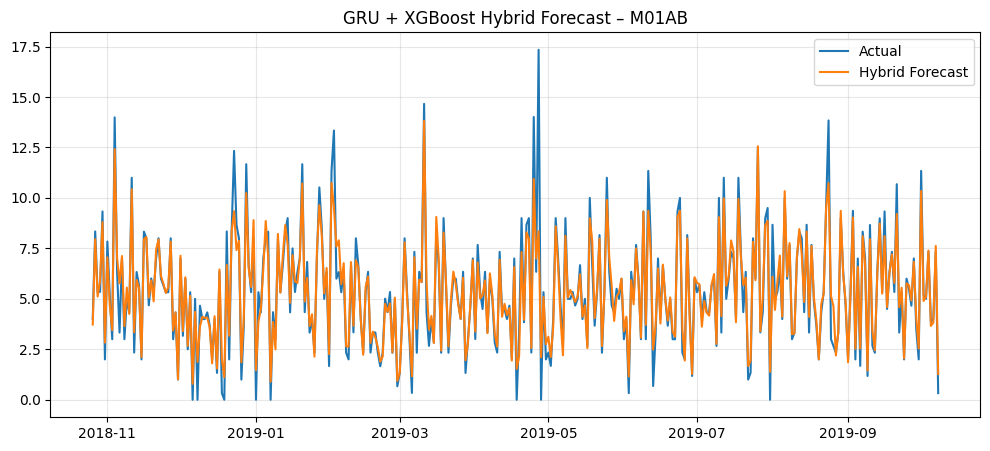


Next 5-Day Forecast:
2019-10-09: 2.78
2019-10-10: 2.99
2019-10-11: 3.03
2019-10-12: 3.01
2019-10-13: 3.01

🔹 Forecasting M01AE with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=0.82, MAE=0.55, SMAPE=19.12%, MSE=0.73, R2=0.841


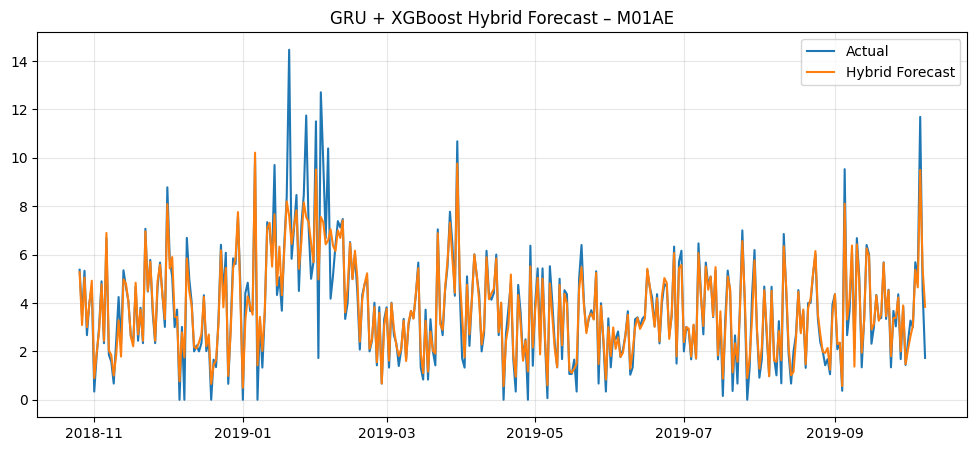


Next 5-Day Forecast:
2019-10-09: 1.96
2019-10-10: 2.08
2019-10-11: 2.22
2019-10-12: 2.34
2019-10-13: 2.31

🔹 Forecasting N02BA with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=0.76, MAE=0.54, SMAPE=23.44%, MSE=0.65, R2=0.874


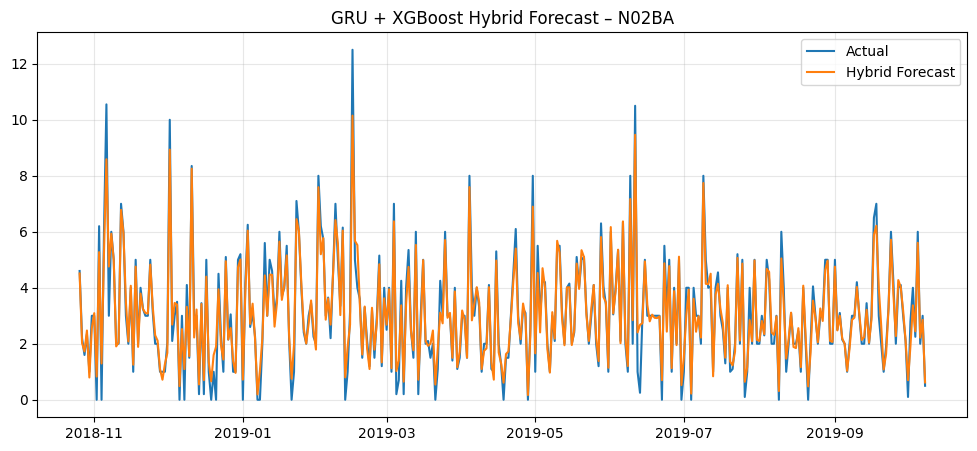


Next 5-Day Forecast:
2019-10-09: 2.55
2019-10-10: 2.47
2019-10-11: 2.47
2019-10-12: 2.44
2019-10-13: 2.44

🔹 Forecasting N02BE with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=7.24, MAE=5.00, SMAPE=18.20%, MSE=58.40, R2=0.770


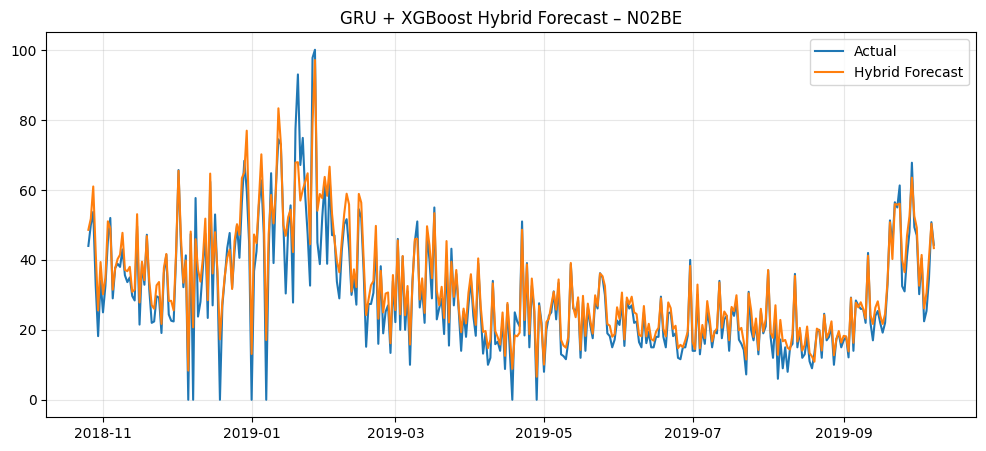


Next 5-Day Forecast:
2019-10-09: 23.49
2019-10-10: 24.09
2019-10-11: 24.59
2019-10-12: 24.86
2019-10-13: 24.42

🔹 Forecasting N05B with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=2.10, MAE=1.50, SMAPE=25.52%, MSE=4.92, R2=0.830


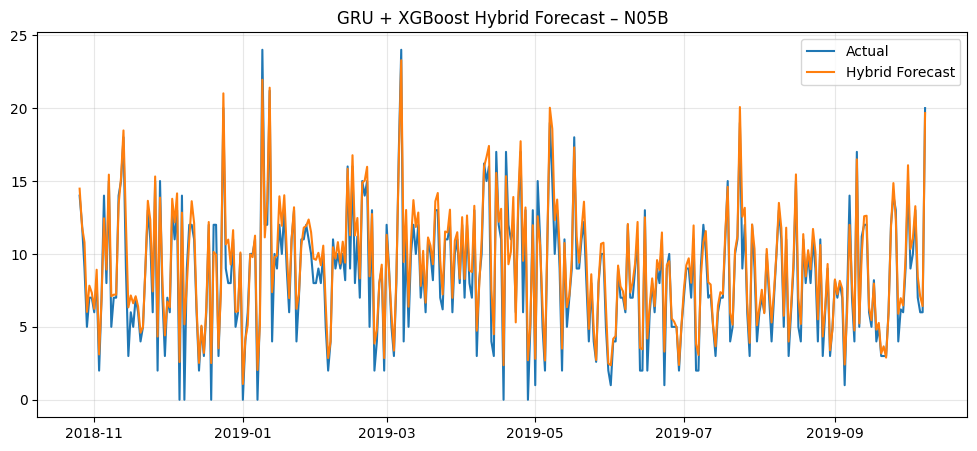


Next 5-Day Forecast:
2019-10-09: 4.50
2019-10-10: 3.49
2019-10-11: 3.03
2019-10-12: 2.97
2019-10-13: 2.99

🔹 Forecasting N05C with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=0.34, MAE=0.13, SMAPE=105.04%, MSE=0.13, R2=0.892


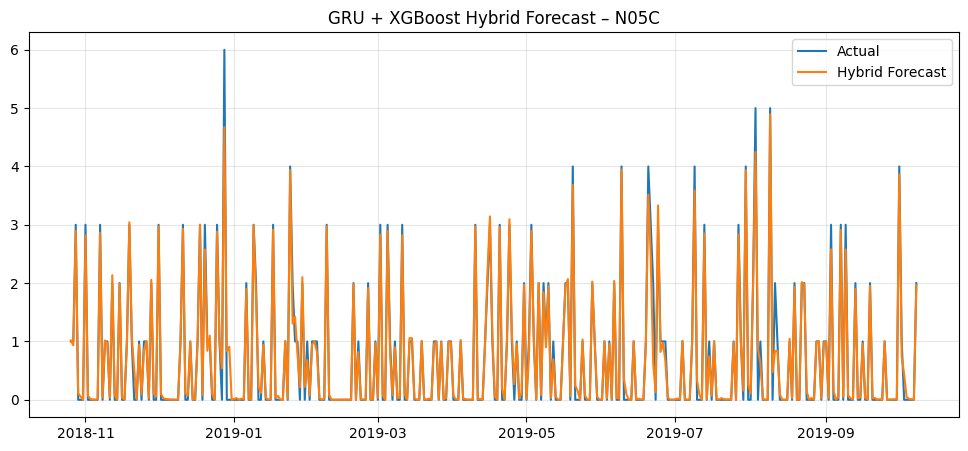


Next 5-Day Forecast:
2019-10-09: 0.00
2019-10-10: 0.02
2019-10-11: 0.03
2019-10-12: 0.03
2019-10-13: 0.02

🔹 Forecasting R03 with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=3.00, MAE=2.04, SMAPE=66.41%, MSE=9.17, R2=0.778


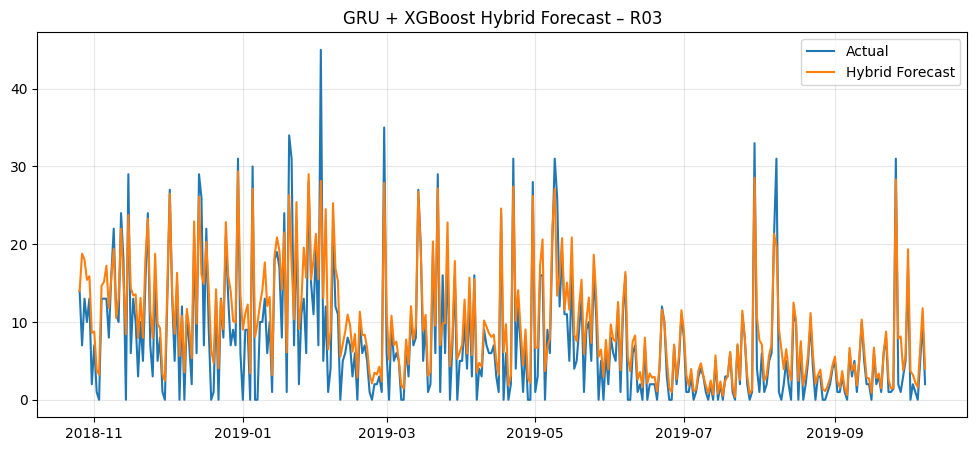


Next 5-Day Forecast:
2019-10-09: 0.84
2019-10-10: 0.60
2019-10-11: 0.57
2019-10-12: 0.55
2019-10-13: 0.52

🔹 Forecasting R06 with GRU + XGBoost
  - Fold 1/5
  - Fold 2/5
  - Fold 3/5
  - Fold 4/5
  - Fold 5/5
  -> Avg Test Metrics: RMSE=2.10, MAE=1.84, SMAPE=64.46%, MSE=5.04, R2=0.212


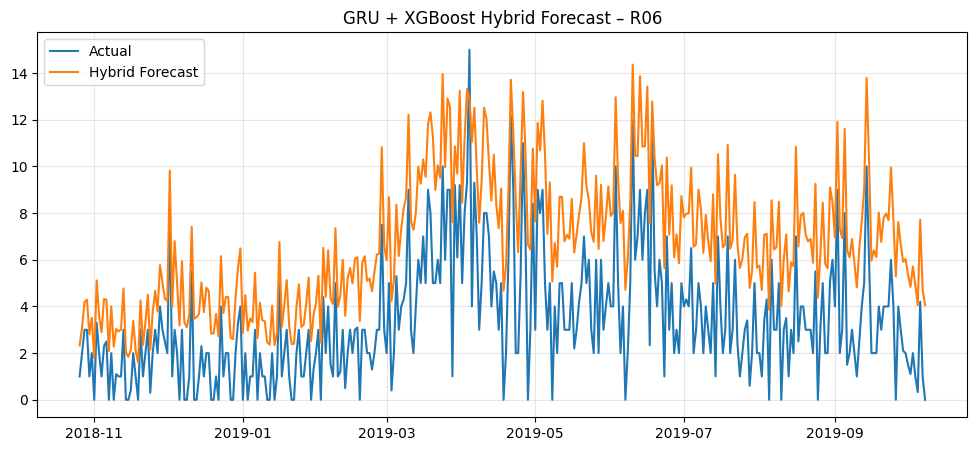


Next 5-Day Forecast:
2019-10-09: 0.74
2019-10-10: 0.59
2019-10-11: 0.52
2019-10-12: 0.45
2019-10-13: 0.43

📊 GRU+XGBoost Forecast Accuracy Summary:
             MSE      RMSE       MAE       SMAPE        R2
M01AB   1.282142  1.090238  0.742835   19.257013  0.829380
M01AE   0.734672  0.815073  0.545836   19.121945  0.840919
N02BA   0.650289  0.760697  0.535707   23.435304  0.874386
N02BE  58.397558  7.241947  4.997654   18.200165  0.769959
N05B    4.924450  2.097046  1.500653   25.519162  0.830340
N05C    0.134842  0.342435  0.130013  105.037029  0.891601
R03     9.171366  3.003312  2.038488   66.412806  0.778186
R06     5.040146  2.100366  1.836293   64.462626  0.212301


In [9]:
results = {}
future_forecasts = {}

for drug in drug_cols:
    name, metrics, forecast, dates = forecast_drug(drug)
    results[name] = metrics
    future_forecasts[name] = pd.Series(forecast, index=dates)

print("\n📊 GRU+XGBoost Forecast Accuracy Summary:")
print(pd.DataFrame(results).T)

Outputs
- **Metrics per drug**: RMSE, MAE, SMAPE, MSE, R².
- **Plots**: Actual vs forecasted sales.
- **Future 5-day predictions** printed per date.